# Lesson 5: Simple chromatographic processes

Chromatography is a thermal separation technique for the separation of mixtures dissolved in a fluid called the mobile phase, which carries the gasous or liquid mixture through a structure holding another material, called the stationary phase.
The various constituents of the mixture travel at different speeds, causing them to separate. 
The separation itself is based on different partitioning between the mobile and stationary phases.

Different mechanisms can be used for the separation, e.g. adsorption, ion exchange, size exclusion to achieve high purities separations of multicomponent mixtures. 
For each mechanism, various stationary phases are available.

Generally, chromatographic models are used for optimization of preparative processes.
In contrast to analytical chromatography, which serves to identify or quantify analytes in a mixture, the purpose of preparative chromatography, is the isolation and purification of sufficient quantities of a specific substance for further use.

For modelling these processes, we have to combine all of the techniques we learnt in the previous lessons:
- Configure unit operations models.
- Associate adsorption models with unit operations.
- Generate dynamic inlet profiles.
- Chemical reactions (if required)

### Load CADETSettings

This imports all the standard libraries and provides some helper functions.

In [ ]:
%run ../utils.ipynb

## Example 1: Dextran pulse

In this exercise, we will consider the following system:

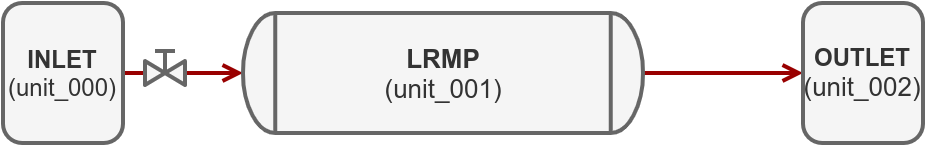

Before considering 'real' chromatography, we will model a simple experiment meant to find the porosity and axial dispersion of a column by sending a dextran pulse through the column. 
There will be no binding or pore penetration yet.

For the injection, we need to Introduce two sections.
In the first section, which lasts $50~s$, the concentration of Dextran at the `INLET` is $1.0~mM$, afterwards it is $1.0~mM$.

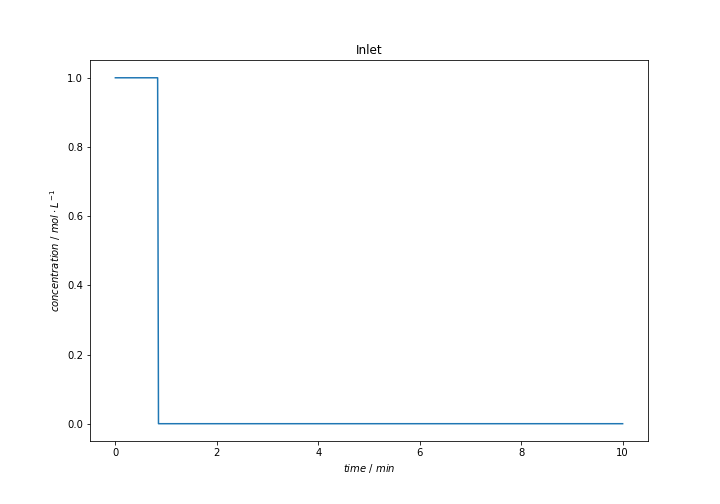

In [ ]:
run_simulation(dextran_model)

time = dextran_model.root.output.solution.solution_times
c = dextran_model.root.output.solution.unit_001.solution_outlet
plt.plot(time, c)
plt.title('Column (Outlet)')
plt.xlabel('$time~/~min$')
plt.ylabel('$concentration~/~mol \cdot L^{-1} $')

## Example 2: Multi component Langmuir separation

Now, we will use the same system, but add `MULTI_COMPONENT_LANGMUIR` model to the column with two components using batch elution chromatography.
This process is often used for the purification of small molecules like amino acids or sugars.

Again, we create two sections to model the injections.

In [ ]:
run_simulation(langmuir_model)

time = langmuir_model.root.output.solution.solution_times
c = langmuir_model.root.output.solution.unit_001.solution_outlet
plt.plot(time, c)
plt.title('Column (Outlet)')
plt.xlabel('$time~/~min$')
plt.ylabel('$concentration~/~mM$')
plt.show()  

## Example 3: Load wash elute with steric mass action law binding

The [steric mass action model](https://cadet.github.io/modelling/binding/steric_mass_action.html#steric-mass-action-model) takes charges of the molecules into account and is, thus, often used in ion-exchange chromatography.
Each component has a characteristic charge $\nu$ that determines the number of available binding sites $\Lambda$ (ionic capacity) used up by a molecule.
Due to the molecule’s shape, some additional binding sites (steric shielding factor $\sigma$) may be shielded from other molecules and are not available for binding.

$$\frac{\mathrm{d} q_i}{\mathrm{d} t} = k_{a,i} c_{p,i}\bar{q}_0^{\nu_i} - k_{d,i} q_i c_{p,0}^{\nu_i}$$

where $c_{p,0}$ denotes the mobile phase salt concentration, and

$$\bar{q}_0 = \Lambda - \sum_{j=1}^{N_{\text{comp}} - 1} \left( \nu_j + \sigma_j \right) q_j$$

is the number of available binding sites which is related to the number of bound salt ions. Using the parameter transformation

$$k_{a,i} = \tilde{k}_{a,i} q_{\text{ref}}^{-\nu_i}$$

$$k_{d,i} = \tilde{k}_{d,i} c_{\text{ref}}^{-\nu_i}$$

we obtain the modified model equation:

$$\frac{\mathrm{d} q_i}{\mathrm{d} t} = \tilde{k}_{a,i} c_{p,i} \left(\frac{\bar{q}_0}{q_{\text{ref}}}\right)^{\nu_i} - \tilde{k}_{d,i} q_i \left(\frac{c_{p,0}}{c_{\text{ref}}}\right)^{\nu_i}$$

This transformation serves as a (partial) nondimensionalization of the adsorption and desorption rates.

The basic goal is to have $\left(\frac{\bar{q}_0}{q_{\text{ref}}}\right) \leq 1$ and $\left(\frac{c_{p,0}}{c_{\text{ref}}}\right) \leq 1$

Recommended choices for $c_{\text{ref}}$ are the average or maximum inlet concentration of the mobile phase modifier $c_0$, and for $q_{\text{ref}}$ the ionic capacity $\Lambda$.
Note that setting the reference concentrations to ${1.0}$ each results in the original binding model.

<div class="alert alert-info">

**Note:** 

From a practical perspective, modern resins have a very high capacity and large proteins can can have a very high charactistic charge.
If the concentration is not normalized, the system is often numerically unstable.
It may run slowly or not at all.

</div>

In this example, we will look at a typical process for protein purification.
First, protein which is in a mixture with salt is loaded on the column and binds to the resin.
Then, the column is washed with a lower concentrated salt solution.
Finally, the protein is eluted by adding a linear salt gradient.

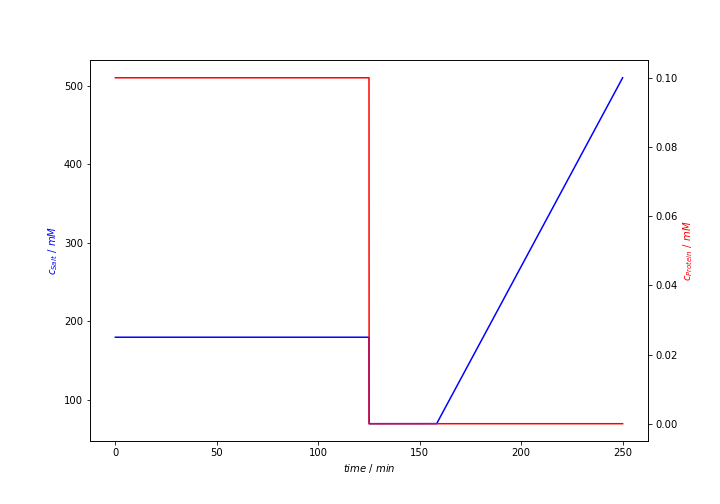

In this case, we will first define the inlet profile, because we need the information for later parameters.
The protein is loaded for $7500 s$, then there is a wash step, which takes $2000 s$, and the gradient takes another $5500 s$.

Then, we define the system of unit operations.

Next, we define the parameters for the `STERIC_MASS_ACTION` model.
As mentioned earlier, we consider a reference concentration in the pore for numeric purposes.
From the [manual](https://cadet.github.io/modelling/binding/reference_concentrations.html?highlight=reference):
> Recommended choices for cref are the average or maximum inlet concentration of the mobile phase modifier c0, and for qref the ionic capacity Λ

***Note:*** `lambda` is a reserved keyword in Python.
In such occasions, it is common to suffix variable names with an underscore.

Finally, we set the initial conditions of the column.
We assume, that in the beginning of the process, the stationary phase is fully loaded with  salt.

Now, we run the simulation and plot the results. Because the concentration ranges are very different, we use different scales for both components.

In [ ]:
run_simulation(lwe_model)

#plot the simulation
fig, ax1 = plt.subplots()

ax1.plot(lwe_model.root.output.solution.solution_times,
    lwe_model.root.output.solution.unit_002.solution_outlet[:,0], 'k', label='Salt')
ax1.set_xlabel('Time(s)')
ax1.set_ylabel('Concentration (mM)')

ax2 = ax1.twinx()

ax2.plot(lwe_model.root.output.solution.solution_times,
    lwe_model.root.output.solution.unit_002.solution_outlet[:,1], 'r', label='Protein')
ax2.set_ylabel('Concentration (mM)')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2)